### Installing dependencies

In [12]:
"""
Install required packages using pip.

Packages:
- pandas
- seaborn
- matplotlib
- scikit-learn
- numpy
- openpyxl
- pipenv

Usage: %pip install pandas seaborn matplotlib scikit-learn numpy openpyxl pipenv
"""
%pip install pandas seaborn matplotlib scikit-learn numpy openpyxl pipenv

Note: you may need to restart the kernel to use updated packages.


### Importing the necessary libraries for the workflow.

In [13]:
"""
Installed packages are loaded using the import statement. The # type: ignore comment is used to suppress warnings.
"""
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.decomposition import PCA # type: ignore
from sklearn.experimental import enable_iterative_imputer  # type: ignore
from sklearn.impute import IterativeImputer  # type: ignore

### Loading data

In [14]:
"""
Load data from an Excel file and extract specific features.
"""
print("Loading data...")
data = pd.read_excel("data/01. Master_Latest data_Control clones_LP.xlsx", engine='openpyxl')
data_extracted_features = pd.read_excel("data/01. Master_Latest data_Control clones_LP.xlsx", usecols=['Batch number', 'Genotype Neuron', 'Div calculated', 'Culture treatment', 'Capacitance', 'Input Resistance', 'Resting membrane potential ', 'Maximum firing ', 'Calculated input resistance', 'Rheobase', 'EPSC freq'])
print("\n")
print(data_extracted_features)


Loading data...


     Batch number Genotype Neuron  Div calculated   Culture treatment  \
0               1         TSC12.3              33                none   
1               1         TSC12.3              33                none   
2               1         TSC12.3              33                none   
3               1         TSC12.3              33                none   
4               1         TSC12.3              33                none   
..            ...             ...             ...                 ...   
683             3             WTC              58                none   
684             3             WTC              58  microglia 6 weekes   
685             3             WTC              58                none   
686             3             WTC              58                none   
687             3             WTC              58  microglia 6 weekes   

     Capacitance  Input Resistance  Resting membrane potential   \
0           54.0            2100.0    

### Preprocessing data

### Violin plot before preprocessing

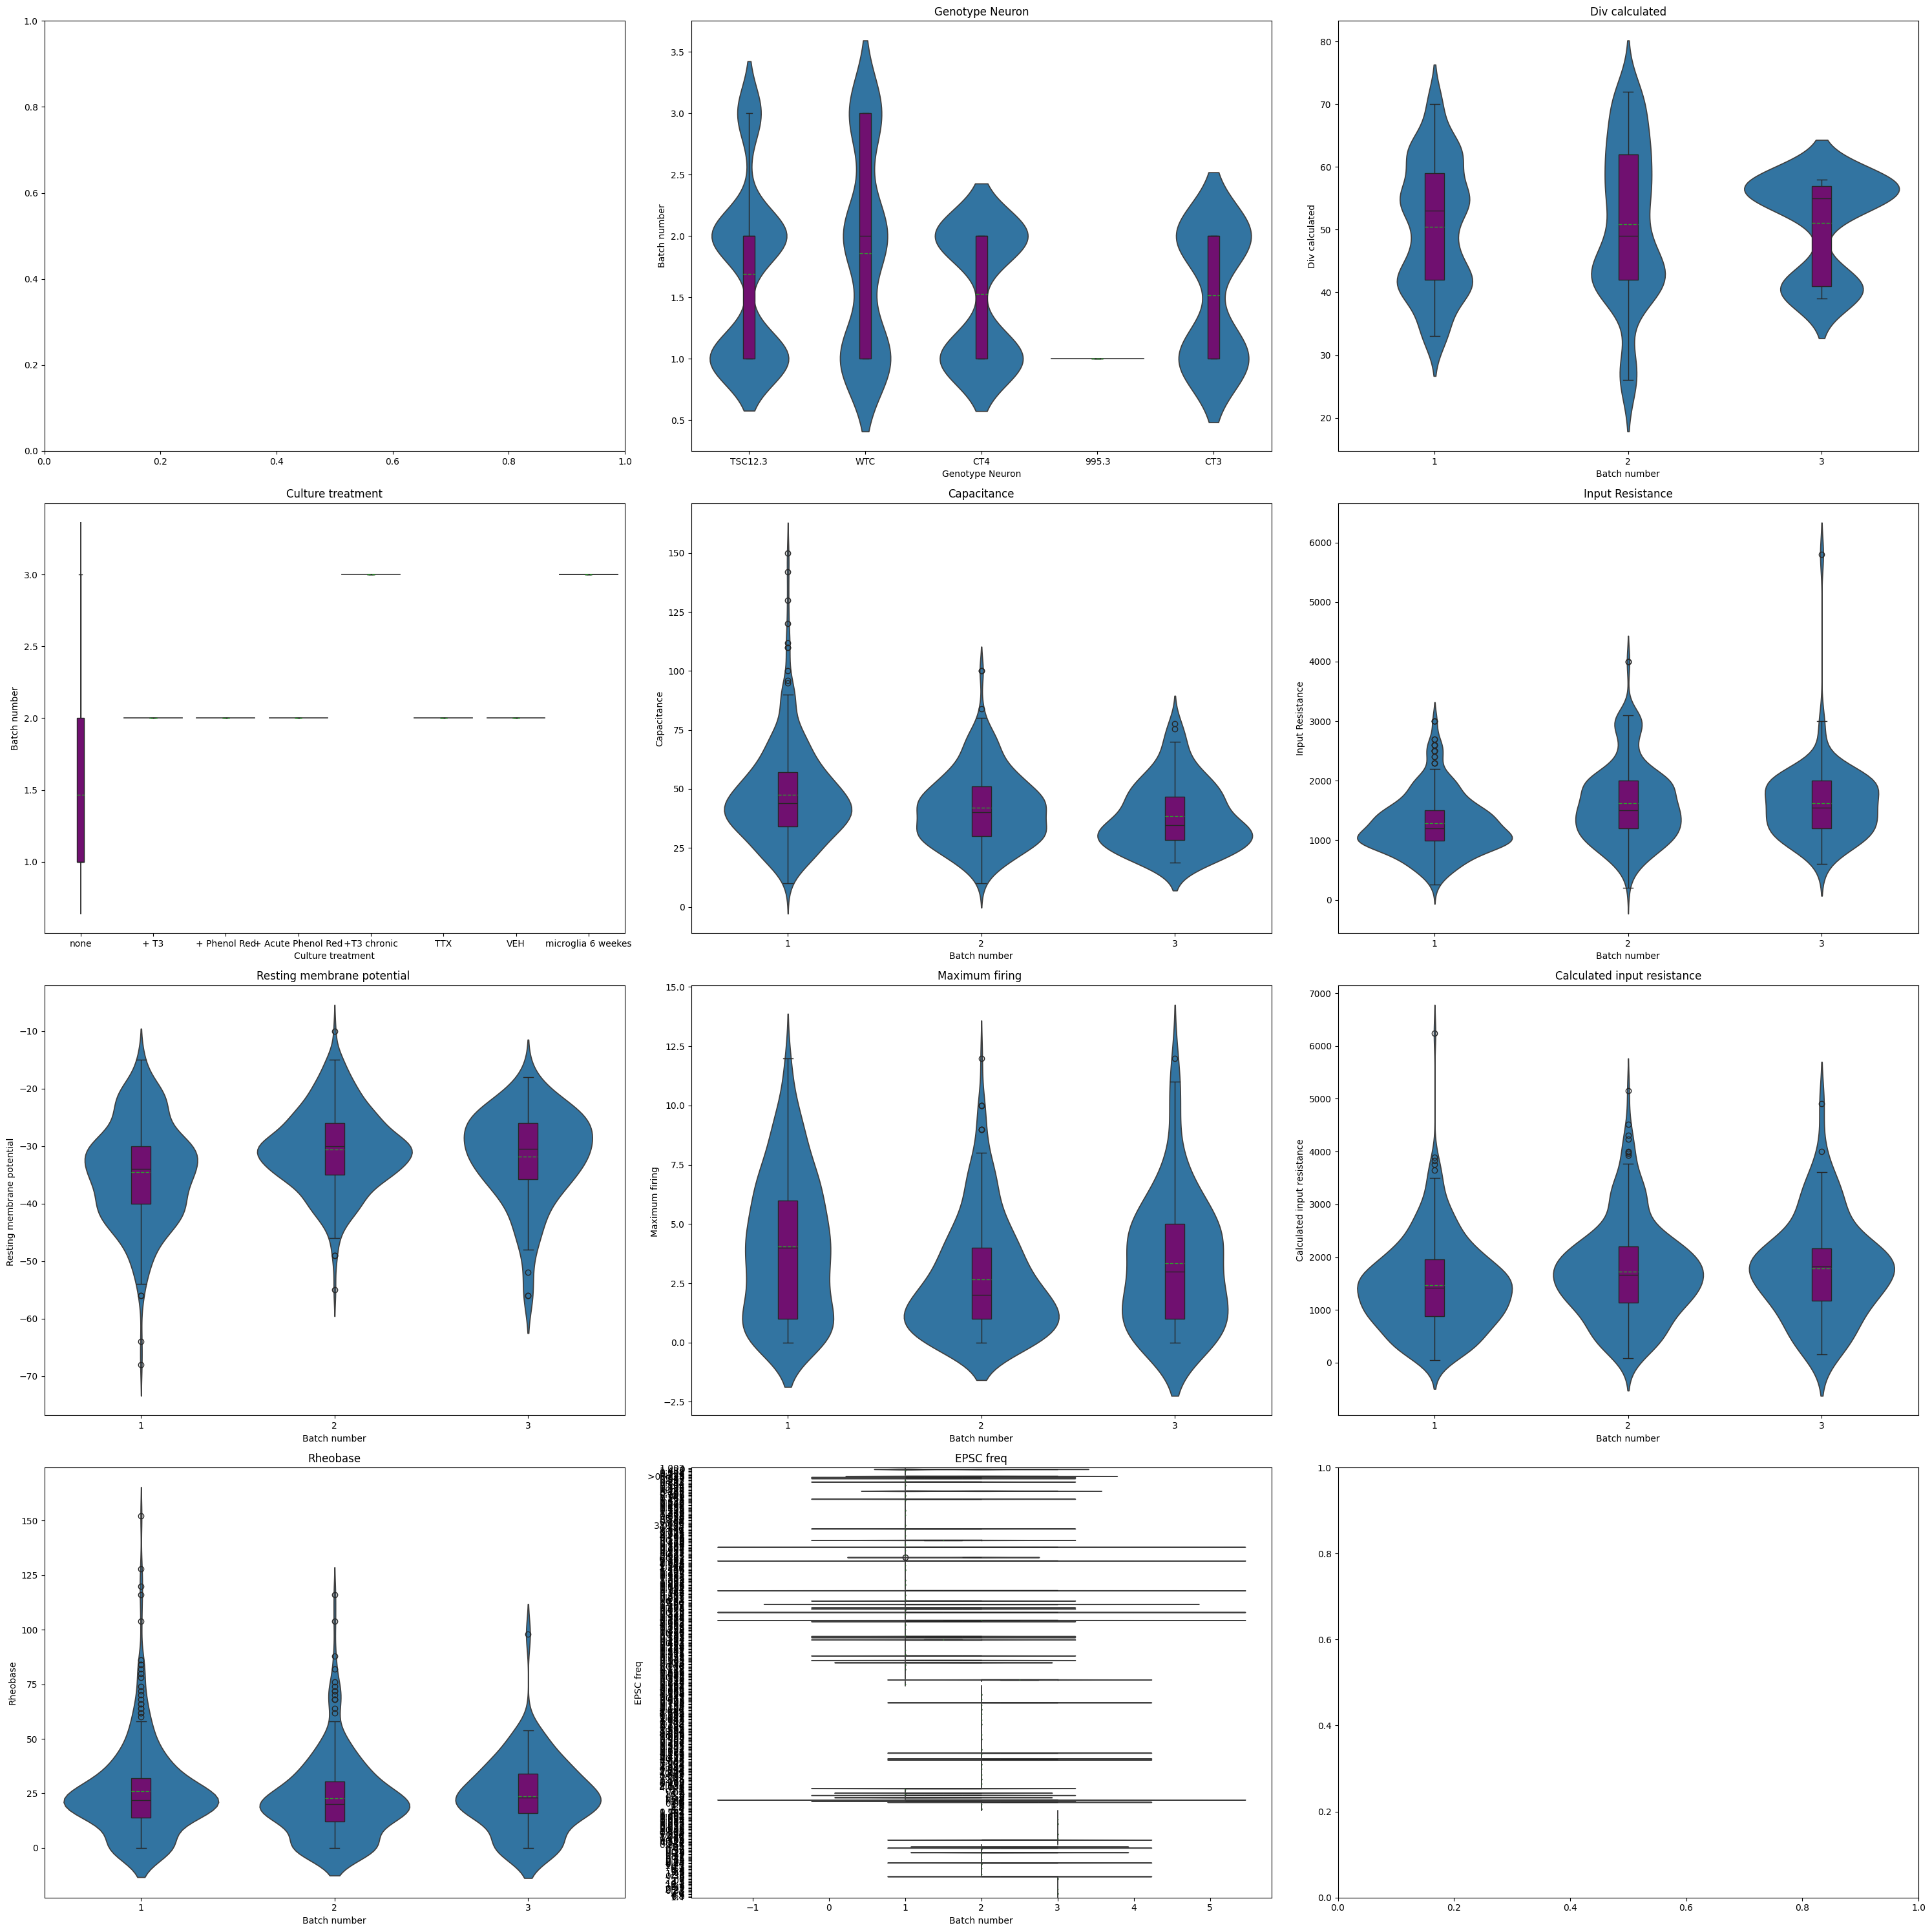

In [15]:
"""
Plots violin and box plots for each feature in the given DataFrame.
"""

# Create a copy of the DataFrame
data_extracted_features_violin_pre = data_extracted_features.copy()

# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(30, 30))
axes = axes.flatten()

# Iterate over each feature in the DataFrame
for i, feature in enumerate(data_extracted_features_violin_pre.columns): 
    if feature == 'Batch number':
        continue
    elif feature == 'Genotype Neuron':
        # Plot violin and box plots for 'Genotype Neuron'
        sns.violinplot(x=feature, y='Batch number', data=data_extracted_features_violin_pre, ax=axes[i], inner=None)
        sns.boxplot(x=feature, y='Batch number', data=data_extracted_features_violin_pre, ax=axes[i], width=0.1, color="purple", showmeans=True, meanline=True)
        axes[i].set_title(feature)
    elif feature == 'Culture treatment':
        # Plot violin and box plots for 'Culture treatment'
        sns.violinplot(x=feature, y='Batch number', data=data_extracted_features_violin_pre, ax=axes[i], inner=None)
        sns.boxplot(x=feature, y='Batch number', data=data_extracted_features_violin_pre, ax=axes[i], width=0.1, color="purple", showmeans=True, meanline=True)
        axes[i].set_title(feature)
    else:
        # Plot violin and box plots for other features
        sns.violinplot(x='Batch number', y=feature, data=data_extracted_features_violin_pre, ax=axes[i], inner=None)
        sns.boxplot(x='Batch number', y=feature, data=data_extracted_features_violin_pre, ax=axes[i], width=0.1, color="purple", showmeans=True, meanline=True)
        axes[i].set_title(feature)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


### MICE imputation

In [16]:
"""
Imputes missing values in the given DataFrame using the IterativeImputer algorithm.
"""

# Initialize the IterativeImputer
imputer = IterativeImputer(random_state=0)

# Replace '>' values with NaN in 'EPSC freq' column
mask = data_extracted_features['EPSC freq'].notna() & data_extracted_features['EPSC freq'].str.contains(">")
data_extracted_features.loc[mask, 'EPSC freq'] = np.nan

# Convert 'EPSC freq' column to numeric
data_extracted_features['EPSC freq'] = pd.to_numeric(data_extracted_features['EPSC freq'])

# Drop object columns for imputation
object_columns = data_extracted_features.select_dtypes(include=['object']).columns
data_extracted_features_impute_copy = data_extracted_features.drop(columns=object_columns)

# Impute missing values
data_extracted_features_imputed = imputer.fit_transform(data_extracted_features_impute_copy)
data_extracted_features_imputed = pd.DataFrame(data_extracted_features_imputed, columns=data_extracted_features_impute_copy.columns)

# Add back the object columns
for column in object_columns:
    data_extracted_features_imputed[column] = data_extracted_features[column]

# Print imputed values for each column
for column in data_extracted_features.columns:
    missing_mask_column = data_extracted_features[column].isnull()
    imputed_missing_mask_column = data_extracted_features_imputed[column].isnull()
    imputed_values_mask_column = (missing_mask_column) & (~imputed_missing_mask_column)
    imputed_values_column = data_extracted_features.loc[imputed_values_mask_column, column]
    imputed_value = data_extracted_features_imputed.loc[imputed_values_mask_column, column]
    if not imputed_values_column.empty:
        imputed_value_pairs = [(original, imputed) for original, imputed in zip(imputed_values_column, imputed_value)]
        print(f"Imputed values for {column}:")
        formatted_output = "\n".join([f"Index: {index + 2}\nOriginal Value: {original} --> Imputed value: {imputed}" for index, (original, imputed) in zip(imputed_values_column.index, imputed_value_pairs)])
        print(formatted_output + "\n")



Imputed values for Input Resistance:
Index: 651
Original Value: nan --> Imputed value: 1364.261752359775

Imputed values for Maximum firing :
Index: 632
Original Value: nan --> Imputed value: 2.2877776655061437
Index: 637
Original Value: nan --> Imputed value: 2.383535930035401

Imputed values for Calculated input resistance:
Index: 5
Original Value: nan --> Imputed value: 2463.573796853375
Index: 8
Original Value: nan --> Imputed value: 1689.2719019092024
Index: 11
Original Value: nan --> Imputed value: 1951.066673717263
Index: 21
Original Value: nan --> Imputed value: 1643.5939425633028
Index: 22
Original Value: nan --> Imputed value: 2180.369131643525
Index: 31
Original Value: nan --> Imputed value: 1935.4232154372742
Index: 65
Original Value: nan --> Imputed value: 1675.7906400101533
Index: 66
Original Value: nan --> Imputed value: 1264.5124415514279
Index: 67
Original Value: nan --> Imputed value: 1295.9082110403847
Index: 78
Original Value: nan --> Imputed value: 1009.27503896392

### Violin plot after preprocessing

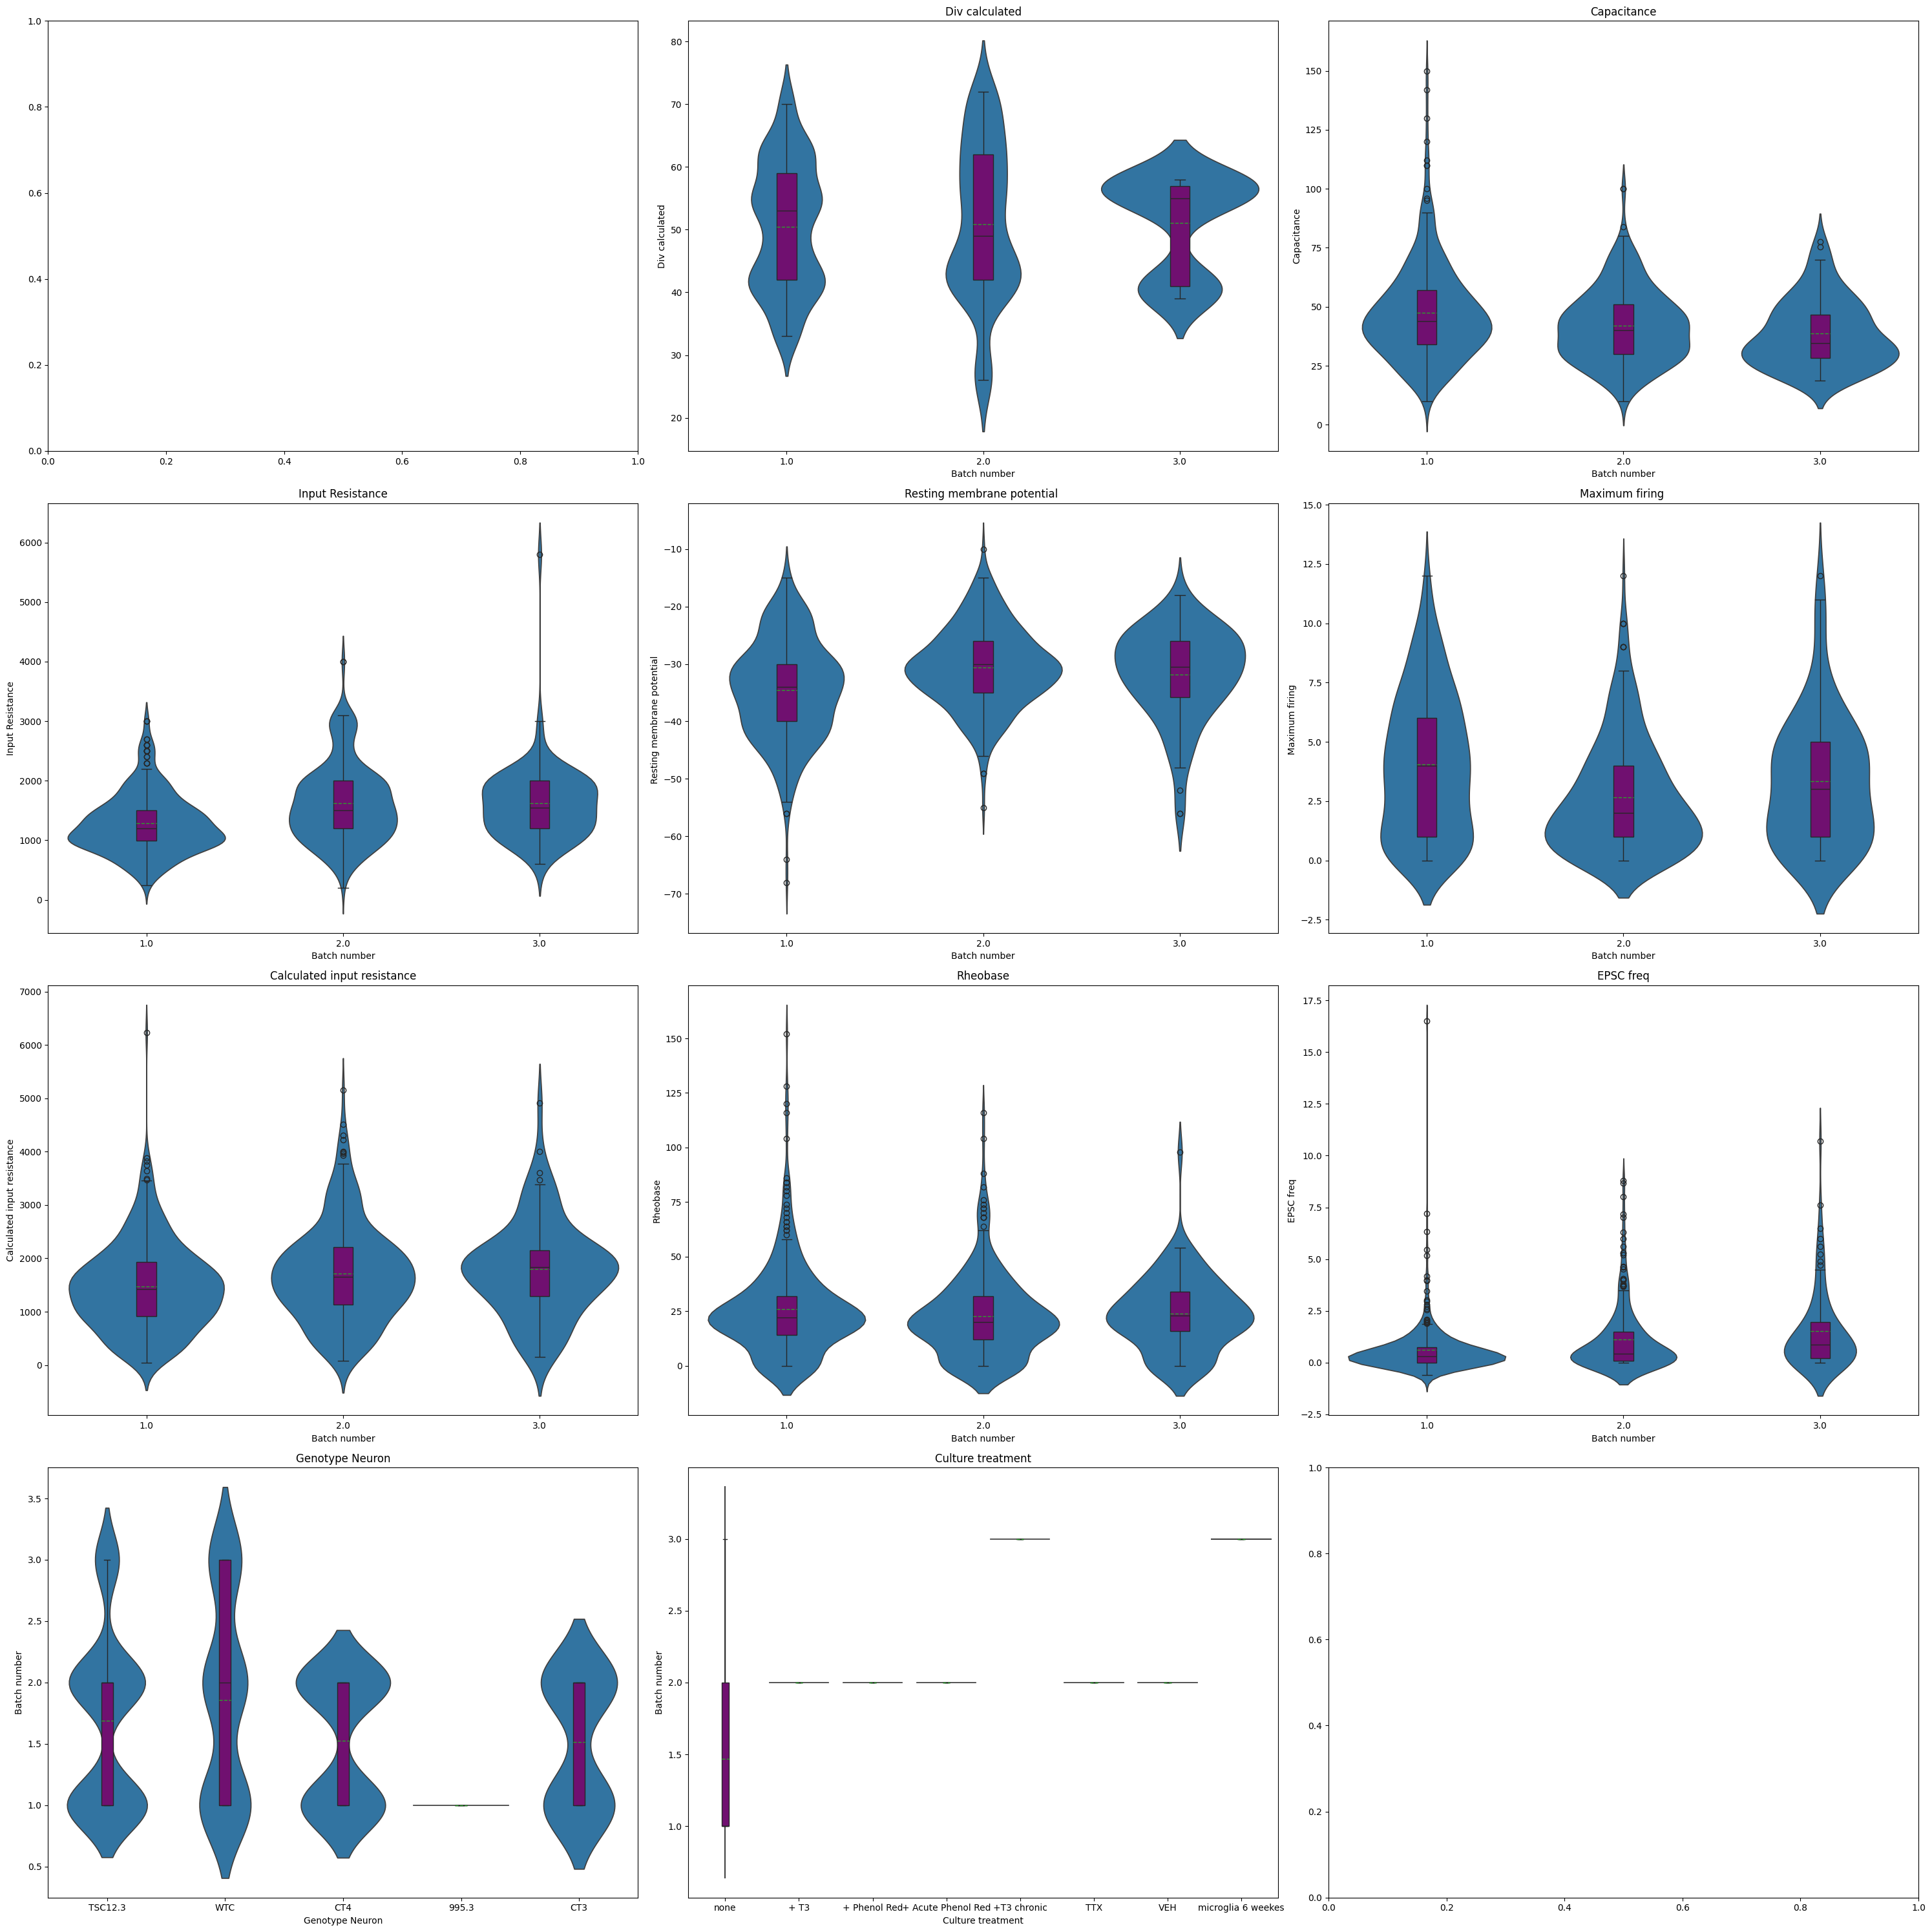

In [17]:

"""
Plots violin and box plots for each feature against the 'Batch number' column.
"""

# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(30, 30))
axes = axes.flatten()

# Iterate over each feature in the DataFrame
for i, feature in enumerate(data_extracted_features_imputed.columns):
    if feature == 'Batch number':
        continue
    elif feature == 'Genotype Neuron':
        # Plot violin and box plots for 'Genotype Neuron'
        sns.violinplot(x=feature, y='Batch number', data=data_extracted_features_imputed, ax=axes[i], inner=None)
        sns.boxplot(x=feature, y='Batch number', data=data_extracted_features_imputed, ax=axes[i], width=0.1, color="purple", showmeans=True, meanline=True)
        axes[i].set_title(feature)
    elif feature == 'Culture treatment':
        # Plot violin and box plots for 'Culture treatment'    
        sns.violinplot(x=feature, y='Batch number', data=data_extracted_features_imputed, ax=axes[i], inner=None)
        sns.boxplot(x=feature, y='Batch number', data=data_extracted_features_imputed, ax=axes[i], width=0.1, color="purple", showmeans=True, meanline=True)
        axes[i].set_title(feature)  
    else:
        # Plot violin and box plots for other features  
        sns.violinplot(x='Batch number', y=feature, data=data_extracted_features_imputed, ax=axes[i], inner=None)
        sns.boxplot(x='Batch number', y=feature, data=data_extracted_features_imputed, ax=axes[i], width=0.1, color="purple", showmeans=True, meanline=True)
        axes[i].set_title(feature)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()
